In [1]:
from tqdm import trange

import helper
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib import animation

import pickle

/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:163: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:184: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [2]:
rules = [102] #30,22, 126,154,18,122,70, 54, 94, 50, 62,110, 90, 150

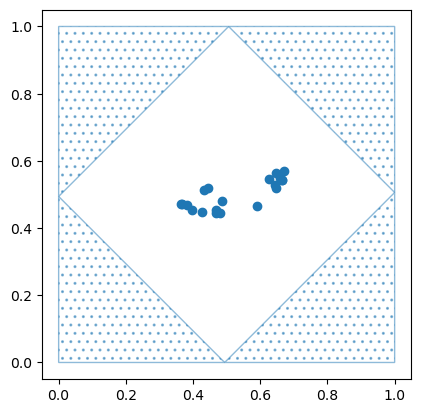

(15, 39596000) 9899
(15, 39596000) 9899
(15, 39596000) 9899


100%|██████████| 9898/9898 [00:09<00:00, 1095.04it/s]


In [3]:
for rule in rules:
    root="~/scratch/detailed_save/"
    folders = ["variable","static","static"]
    seed_ints = ["69904-149796","69904","149796"]
    season_lens=[300,100_000,100_000]
    rules = [f"{rule}-{rule}", rule, rule]
    num_repeats = 15

    pop_size = 20
    grn_size=22
    dev_steps = 22
    num_cells = 22
    geneid=1
    try_seedints = [69904,149796]

    all_targs=[]
    for s in try_seedints:
        random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
        #targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, r, s)
        start_pattern = helper.seedID2string(s, num_cells)
        start_expression = helper.seed2expression(start_pattern, pop_size, num_cells, grn_size, geneid)
        targets = helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
        all_targs.append(targets)

    pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
    target1, _, fitnesses1 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[0], try_seedints[0])
    target2, _, fitnesses2 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1], try_seedints[1])

    landmarks=helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)

    root="~/scratch/detailed_save/"
    folders = ["variable","static","static"]
    seed_ints = ["69904-149796","69904","149796"]
    season_lens=[300,100_000,100_000]
    rules = [f"{rule}-{rule}", rule, rule]
    num_repeats = 15
    pop_size = 1000

    all_fits = []
    for g in range(len(season_lens)):
        fits=[np.loadtxt(os.path.expanduser(root+f"{folders[g]}/stats_{season_lens[g]}_{rules[g]}_{seed_ints[g]}_{i+1}_both_fits.txt")) for i in range(num_repeats)]
        fits = np.array(fits)
        num_gens = int(fits.shape[1]/2/pop_size)
        fits = fits.reshape(num_repeats, num_gens, 2, pop_size)
        all_fits.append(fits)
    all_fits=np.vstack(all_fits)
    all_fits=np.reshape(all_fits, (3, num_repeats, num_gens, 2, pop_size ))

    pop_size = 1000

    all_edges = []
    for g in range(len(season_lens)):
        edges=[np.loadtxt(os.path.expanduser(root+f"{folders[g]}/stats_{season_lens[g]}_{rules[g]}_{seed_ints[g]}_{i+1}_edges.txt")) for i in range(num_repeats)]
        edges = np.array(edges).astype(int) 
        num_generations=int(edges.shape[1]/4/pop_size)
        print(edges.shape, num_generations)
        edges = edges.reshape(num_repeats, num_generations*pop_size, 2, 2)
        all_edges.append(edges)
    all_edges=np.vstack(all_edges)
    all_edges=np.reshape(all_edges, (3, num_repeats, num_generations*pop_size, 2, 2 ))

    kid_fits = np.zeros((3,num_repeats,num_generations-1,2, 100,10))
    for e in range(3):
        for rep in range(num_repeats):
            for g in trange(num_generations-1): #last gen has kids but no fitnesses computed
                start = g*pop_size
                stop = g*pop_size + pop_size
                a = all_edges[e,rep,start:stop, :, :] #first generation, gen 0
                unique_first_positions, inverse_indices = np.unique(a[:, 0], axis=0, return_inverse=True)
                #print(unique_first_positions.shape) #100, parents
                #print(inverse_indices.shape) #1000, kids, including surviving parents
                b = np.array([a[:, 1][inverse_indices == i] for i in range(len(unique_first_positions))]) #for each parent, 10 kids, 2d id
                b = b[:,:,1] #only second id is interesting
                b_flattened = b.reshape(pop_size)
                b_fits = all_fits[e,rep,g+1,:,:][:,b_flattened] #have to be looking 1 gen down
                b_fits = b_fits.reshape(2, 100, 10) #the 2 fitness values, num parents, num kids
                #print(b_fits[1,3,5]) #fitness2 of the sixth kid of the fourth parent
                #print(all_fits[0,0,1,1,777]) #fitness2 of the 777th individual in the population in the second generation
                kid_fits[e,rep,g,:,:,:] = b_fits

    div_BH, div_BH_mean = helper.calc_div_BH(kid_fits, landmarks)

    pickle.dump(div_BH_mean, open(f"diversify_{rule}.p", "wb" ) )

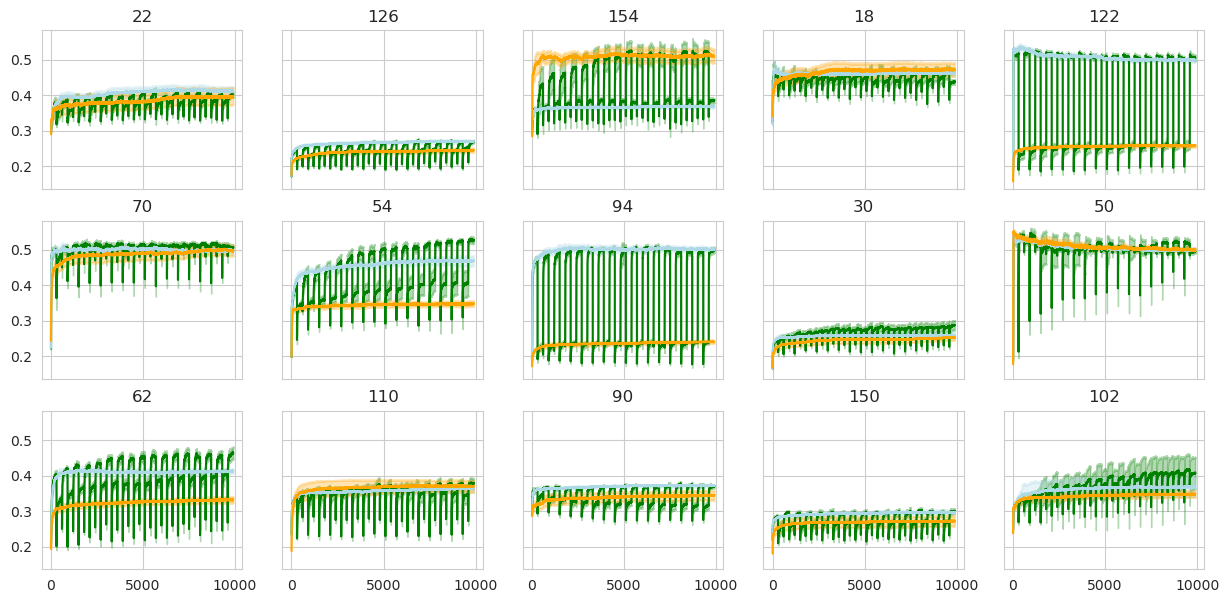

In [4]:
num_reps = 15
z_value = 1.96  # For a 95% confidence interval
labels=["vari","env1","env2"]
colors = ["green", "lightblue", "orange"]

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),sharex=True, sharey=True)
axes = axes.flatten()

rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]

for idx, rule in enumerate(rules):

    div_BH_mean = pickle.load(open(f"diversify_{rule}.p", "rb"))
    
    for i in range(3):
        mean1 = div_BH_mean[i,:,:].mean(axis = 0)
        stderr1 = np.std(div_BH_mean[i,:,:], axis=0) / np.sqrt(num_reps)
        ci_upper = mean1 + z_value * stderr1
        ci_lower = mean1 - z_value * stderr1
        axes[idx].fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3,color=colors[i])
        axes[idx].plot(mean1, "-", label= labels[i], color=colors[i])
        axes[idx].set_title(f"{rule}")
    #plt.legend()